# Test segmentation models package install
## 04/03/21
Installed `semgmentation_models_pytorch` and `albumentations` via pip. The content of this notebook started from the `smp` [tutorial](https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/cars%20segmentation%20(camvid).ipynb). Several modifications were necessary drawn. To do multiclass segmentation the code needs consistent mapping from mask pixel value to class. There were several useful [posts](https://discuss.pytorch.org/t/error-in-python-s-multiprocessing-library/31355/6) in [pytorch](https://discuss.pytorch.org/t/multiclass-segmentation/54065/7) [forums](https://discuss.pytorch.org/t/training-semantic-segmentation/49275/4).

In [1]:
%matplotlib inline

import os
import glob
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import cv2
import segmentation_models_pytorch as smp
import albumentations as alb

In [2]:
# prelims
vocpath = '/home/eorenstein/VOCCopepodEgg'
imgset = 'SplitProf-obj-detect-240221'

A helper function for quick visualization

In [3]:
def visualize(**images):
    """
    plot images in a row
    :param images: what to plot paired with desired title [title=array]
    """
    n = len(images)
    if 'mask' in images.keys():
        n += images['mask'].shape[2]-1
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        if name == 'mask':
            for jj in range(image.shape[2]):
                plt.subplot(1, n, i + 1 + jj)
                plt.xticks([])
                plt.yticks([])
                plt.title(f'Mask channel: {jj}'.title(), fontsize=18)
                plt.imshow(image[:, :, jj])
        elif name == 'ROI':
            plt.subplot(1, n, i + 1)
            plt.xticks([])
            plt.yticks([])
            plt.title(' '.join(name.split('_')).title(), fontsize=18)
            plt.imshow(image, cmap='gray') 
        else:
            plt.imshow(image)
    plt.show()

## Dataset helper class

Instantiate a class for the dataset. Inherit properties from PyTorch's basic dataset class

In [16]:
class Dataset(BaseDataset):
    """
    Egg Dataset. Read images from list in VOC format, apply augmentation and preprocessing transformations.
    :param root: root of VOC-like directory [str]
    :param img_set: path to image list to consider [str]
    :param augs: transforms to preform for augmentations [func]
    :param preproc: preprocessing steps [resize, normalization] [func]
    :return: dataset object
    """
    
    CLASSES = ['copepod', 'eggs']
    
    def __init__(self, root=None, img_set=None, classes=None, augs=None, preproc=None):

        self.root = root
        img_dir = os.path.join(root, 'JPEGImages')
        seg_dir = os.path.join(root, 'SegmentationMask')
        
        # if the image set given is not an absolute path, assume it lives in VOC structure
        if not os.path.isabs(img_set):
            img_set = os.path.join(root, 'ImageSets', 'Main', img_set)
            
        # get the list of image-ids
        with open(img_set, 'r') as ff:
            tmp = list(ff)
            ff.close
        self.ids = [line.strip() for line in tmp]
        self.images = [os.path.join(img_dir, f'{line}.jpg') for line in self.ids]
        self.masks = [os.path.join(seg_dir, f'{line}.png') for line in self.ids]
        self.class_values = [self.CLASSES.index(ii.lower()) for ii in classes]
        
        self.augs = augs
        self.preproc = preproc
        
        # this is the mapping for the pixel values. hardcorded for the moment but could be made more dynamic/useful
        self.mapping = {
            50: 1,
            100: 2
        }
    
    def mask_to_class(self, mask):
        for kk in self.mapping:
            mask[mask==kk] = self.mapping[kk]
        return mask
            
    def __getitem__(self, ii):
        
        # read data
        image = cv2.imread(self.images[ii], cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(self.masks[ii], 0)
        
        # convert mask to numeric labels with the right labels
        mask = self.mask_to_class(mask)
        mks = [(mask==vv+1) for vv in self.class_values]
        mask = np.stack(mks, axis=-1).astype('float')  
        
        # add background if mask not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augs:
            sample = self.augs(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if callable(self.preproc):
            image=np.stack([image, image, image], axis=-1)  # this sets up dummy color channels in order to do imagenet preprocessing
            sample = self.preproc(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

Test the data class.

In [5]:
val_dataset = Dataset(root=vocpath, 
                      img_set=f'{imgset}/val.txt',
                      classes=['copepod', 'eggs']
                     )

The masks should return two channels, the first with the copepod pixels, the second with eggs (will be a blank mask if no eggs)
- ind = 1 has no eggs
- ind = 10, 12 have eggs with different morphologies.

(48, 97, 3)


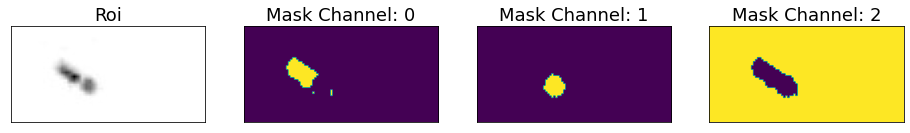

In [6]:
img, mk = val_dataset[2]
print(np.shape(mk))
visualize(ROI=img, mask=mk)

## Define augmentations and preprocessing
Start with a few basic ones since we have O(1000) per class for this first experiment. 
- Horizontal flip
- Vertical flip
- Perspective transform

Also resize everything to 128x128 since need square powers of 2 for training and testing.

In [19]:
def training_transform(ht=128, wd=128):
    """
    compose the training transforms
    :param ht: height for resize [int]
    :param wd: width for resize [int]
    :return transform:
    """
    t_trans = [
        alb.Resize(height=ht, width=wd),
        alb.HorizontalFlip(p=0.5),
        alb.VerticalFlip(p=0.5),
#        alb.PadIfNeeded(256, 256, border_mode=cv2.BORDER_REPLICATE)
        alb.ShiftScaleRotate(p=0.5,
                             border_mode=cv2.BORDER_REPLICATE,
                             #value=255,
                             #mask_value=0
                            ),
        #ToTensor()
    ]
    
    return alb.Compose(t_trans)


def validation_transform(ht=128, wd=128):
    """
    compose the validation transform (just resize)
    :param ht: height for resize [int]
    :param wd: width for resize [int]
    :return transform:
    """
    v_trans = [
        alb.Resize(height=ht, width=wd),
        #alb.PadIfNeeded(256, 256, border_mode=cv2.BORDER_REPLICATE)
        #ToTensor()
    ]
    
    return alb.Compose(v_trans)


def to_tensor(x, **kwargs):
    """
    Transform for GPU
    """
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """
    Preprocessing transform
    :param preprocessing: data normalization function (specific for each pretrained neural network)
    :return transform:
    
    """
    _transform = []
    if preprocessing_fn:
        _transform.append(alb.Lambda(image=preprocessing_fn))
    _transform.append(alb.Lambda(image=to_tensor, mask=to_tensor))
    #ToTensor()
    
    return alb.Compose(_transform)


Now test it with the Dataset class

In [8]:
training_dataset = Dataset(root=vocpath,
                           img_set=f'{imgset}/train.txt',
                           augs=training_transform(),
                           classes=['copepod', 'eggs']
                          )

Make a few plots. This should plot 3 transformas of the same image and the corresponding masks

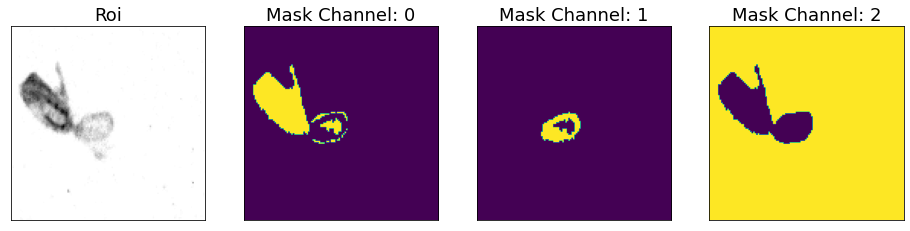

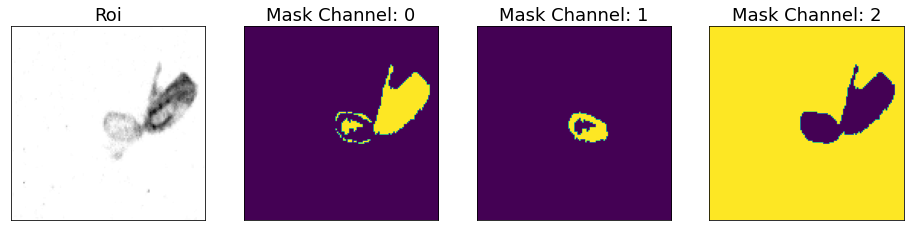

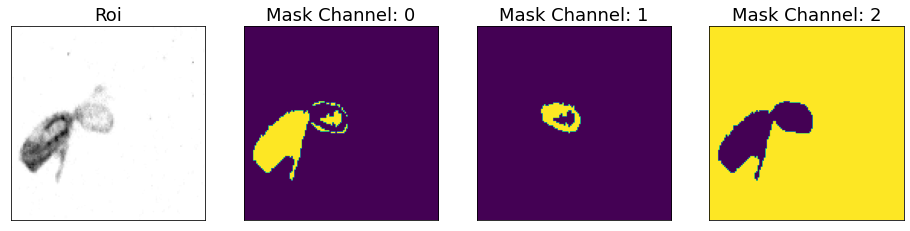

/home/eorenstein/VOCCopepodEgg/SegmentationMask/6650522.png


In [9]:
kk=0
while kk < 3:
    img, mk = training_dataset[270]
    visualize(ROI=img, mask=mk)
    kk+=1

print(training_dataset.masks[270])

## Define the network and dataloaders

Instantiate a UNet. This will return a pytorch model using ResNet-18 pretrained on ImageNet as the encoder. Encoder depth is how many layers of features are used. Per the docs: "in general the deepest feature tensor will have spatial resolution (H/(2^depth), W/(2^depth)." It will be worth experimenting with this. My sense is that we don't want it to be too deep since our original images are so small.

In [10]:
# this is the network model.
CLASSES = ['copepod', 'eggs']
n_classes = 1 if len(CLASSES) == 1 else ((len(CLASSES) + 1))

model = smp.Unet(
    encoder_name="resnet18",
    encoder_weights="imagenet",
#    encoder_depth=3,
#    decoder_channels=(64, 32, 16),
#    in_channels=1,
    classes=n_classes,
    activation="softmax2d"
)

# this is the preprocessing for imagenet
preprocess = smp.encoders.get_preprocessing_fn("resnet18", "imagenet")


Skip the preprocessing step since there is a handler for grayscale images written into the model via `in_channels` arguement. See [this closed SMP issue on git for more.](https://github.com/qubvel/segmentation_models.pytorch/issues/175)

In [16]:
training_dataset = Dataset(root=vocpath,
                           img_set=f'{imgset}/train.txt',
                           augs=training_transform(),
                           preproc=get_preprocessing(preprocess),
                           classes=['copepod','eggs']
                          )

val_dataset = Dataset(root=vocpath, 
                      img_set=f'{imgset}/val.txt',
                      augs=validation_transform(),
                      preproc=get_preprocessing(preprocess),
                      classes=['copepod','eggs']
                     )

train_loader = DataLoader(training_dataset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=1)

## Define loss function

Dice loss is related to the F1 score. IoU is intersection over union.

In [17]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# standard atom optimizer from PyTorch (might want to consider reducing the learning rate)
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

## Define the epoch runners

In [18]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device='cuda',
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device='cuda',
    verbose=True,
)

## Try training

Run the trainer for a few epochs

In [19]:
max_score = 0
outpath = '/home/eorenstein/python_code/eggs-emantic/outputs'
for i in range(0, 15):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(val_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, os.path.join(outpath,'best_model.pth'))
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 626/626 [00:04<00:00, 135.71it/s, dice_loss - 0.07264, iou_score - 0.9403]
Model saved!

Epoch: 1
valid: 100%|██████████| 626/626 [00:04<00:00, 134.64it/s, dice_loss - 0.03064, iou_score - 0.9635]
Model saved!

Epoch: 2
valid: 100%|██████████| 626/626 [00:04<00:00, 133.36it/s, dice_loss - 0.02284, iou_score - 0.9669]
Model saved!

Epoch: 3
valid: 100%|██████████| 626/626 [00:04<00:00, 133.53it/s, dice_loss - 0.02055, iou_score - 0.9668]

Epoch: 4
valid: 100%|██████████| 626/626 [00:04<00:00, 134.38it/s, dice_loss - 0.01886, iou_score - 0.9676]
Model saved!

Epoch: 5
valid: 100%|██████████| 626/626 [00:04<00:00, 133.49it/s, dice_loss - 0.01818, iou_score - 0.9677]
Model saved!

Epoch: 6
valid: 100%|██████████| 626/626 [00:04<00:00, 133.47it/s, dice_loss - 0.01768, iou_score - 0.9677]

Epoch: 7
valid: 100%|██████████| 626/626 [00:04<00:00, 135.00it/s, dice_loss - 0.01747, iou_score - 0.9676]

Epoch: 8
valid: 100%|██████████| 626/626 [00:04<00:00, 133.30i

## Run an image through the best model parameters

Load from the checkpoint that was saved according to best IoU

In [6]:
best_model = torch.load('./outputs/best_model.pth')

In [20]:
# this is the preprocessing for imagenet
preprocess = smp.encoders.get_preprocessing_fn("resnet18", "imagenet")

# for now, just use the validation data
# this version will be used to feed the select ROI through the network
val_dataset = Dataset(root=vocpath, 
                      img_set=f'{imgset}/val.txt',
                      augs=validation_transform(),
                      preproc=get_preprocessing(preprocess),
                      classes=['copepod','eggs']
                     )

# this version is just to see the original mask before transforms. IE no preprocessing, resizing
val_dataset_viz = Dataset(root=vocpath, 
                      img_set=f'{imgset}/val.txt',
                      classes=['copepod','eggs']
                     )

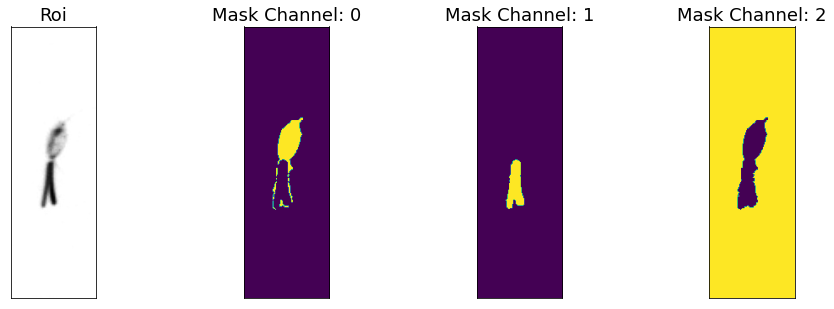

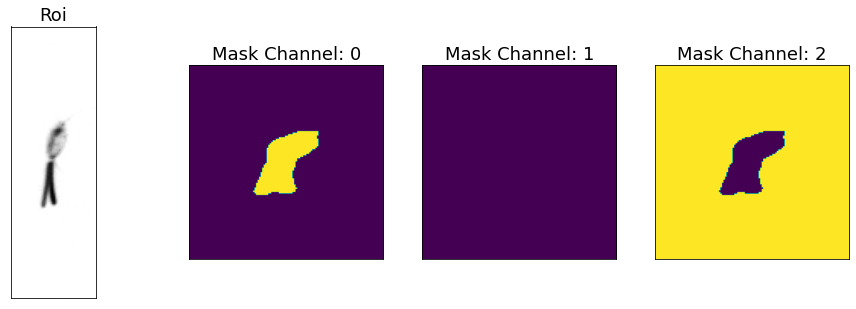

In [22]:
# select a random image from the validation set
#ii = np.random.choice(len(val_dataset))
ii=10

img_orig, gt_mask = val_dataset_viz[ii]
img, mask = val_dataset[ii]

mask = mask.squeeze()

# put it on the GPU
imgtens = torch.from_numpy(img).to('cuda').unsqueeze(0)
pred = best_model.predict(imgtens)
pred = (pred.squeeze().cpu().numpy().round())

# rearrange channels for visualization
pred_out = pred.transpose(1,2,0)

visualize(ROI=img_orig, mask=gt_mask)
visualize(ROI=img_orig, mask=pred_out)